In [347]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import simplegrad.algo.optimize as sgo
import simplegrad as sg
from graphviz import Digraph
import graphviz
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
def bukin_function(x, y):
    return 100 * (abs(y - 0.01 * (x ** 2)) ** (1/2)) + 0.01 * abs(x + 10)


In [238]:
def drawHeatmap(f, center, points=None, points_num_axis = 2* 1e2, delta = 1, ax=None):
    if points is None:
        points = []
    points_num_axis = int(points_num_axis)
    grid = np.mgrid[
           center[0] - delta:center[0] + delta:(points_num_axis* 1j),
           center[1] - delta:center[1] + delta:(points_num_axis* 1j)]
    allPoints = grid.copy().reshape((2, points_num_axis * points_num_axis))
    result = f(allPoints[0, :], allPoints[1, :]).reshape((points_num_axis, points_num_axis)).T[::1,::-1]
    if ax is None:
        plt.figure(figsize=(8, 8))
    sns.heatmap(result, cbar=False, ax=ax)
    if ax is None:
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Function heatmap [{np.min(grid[0])}, {np.max(grid[0])}]x[{np.min(grid[1])}, {np.max(grid[1])}]")
    else:
        ax.set_xticks([])
        ax.set_yticks([])

    points_transformed = []
    for point in [center] + points:
        x = (point[0] - np.min(grid[0])) / (2 * delta / points_num_axis)
        y = (point[1] - np.min(grid[1])) / (2 * delta / points_num_axis)
        points_transformed.append((x, y))
    sns.scatterplot(x=points_transformed[0][0], y = [points_transformed[0][1]], color='crimson', ax=ax)
    points_transformed = np.array(points_transformed[1:])
    if len(points_transformed) > 0:
        sns.lineplot(x=points_transformed[:,0], y=points_transformed[:,1], color='teal', alpha=0.6, sort=False, lw=2, ax=ax)

In [248]:
x, y = sg.Variable(-11), sg.Variable(2)
history = []
loss = []
f = bukin_function(x, y)
f.forward()
f.backward()
optimizer = sgo.Adam(model=f, variables=[x, y], lr=1e-2)

In [249]:
for i in tqdm(range(10000)):
    history.append((x.scalar, y.scalar))
    loss.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
(x.scalar, y.scalar)


  0%|          | 0/10000 [00:00<?, ?it/s]

(-11.61832761051427, 1.3329842661119338)

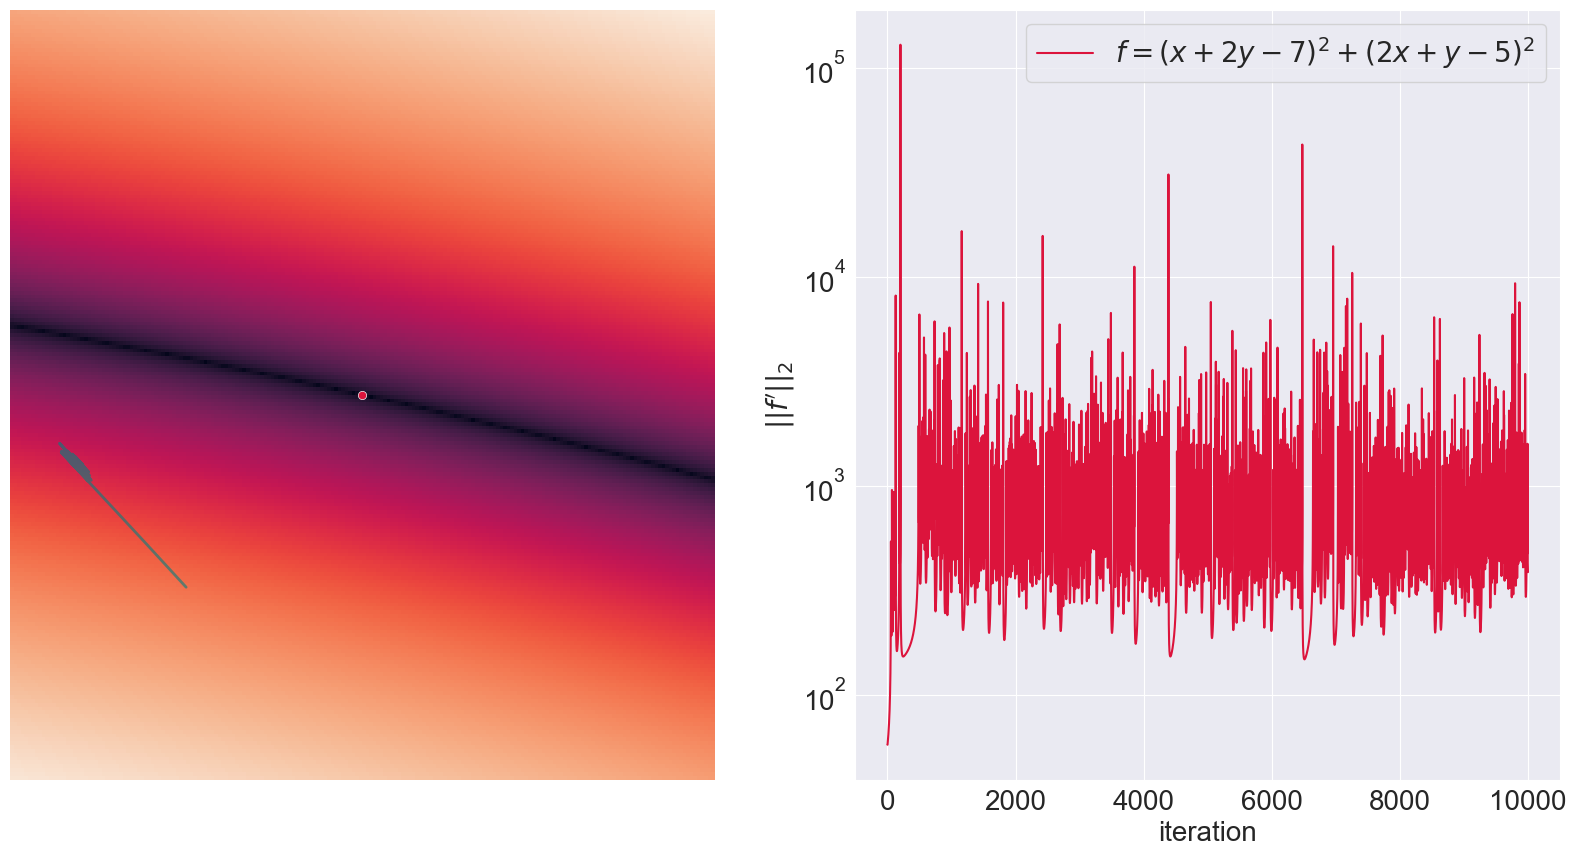

In [251]:
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
drawHeatmap(bukin_function, (-10, 1), points=history, delta=2, ax=ax[0])
# fig.suptitle(f"Booth function optimization, Adam")
sns.lineplot(x=np.arange(1, len(loss) + 1), y=loss, ax=ax[1],
             color='crimson', label="$f=(x + 2y - 7)^2 + (2x + y - 5)^2$")
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("$||f'||_2$")
ax[1].set_yscale('log')
None

In [233]:
x, y = sg.Variable(-11), sg.Variable(2)
f = abs(x * x) + abs(y)
f.forward()
f.backward()
optimizer = sgo.GD(model=f, variables=[x, y], lr=1e-2)
for i in tqdm(range(10000)):
    history.append((x.scalar, y.scalar))
    loss.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    optimizer.step()
(x.scalar, y.scalar)


  0%|          | 0/10000 [00:00<?, ?it/s]

(-2.0051626668895737e-87, -1.6410484082740595e-15)

In [117]:
def boothFunction(x, y):
    return (x + 2 * y - 7) ** 2 + (2 * x + y - 5) ** 2


In [337]:
x, y = sg.Variable(7), sg.Variable(2)
history = []
loss = []
f = boothFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.Adam(model=f, variables=[x, y], lr=1e-4 / 2)

In [338]:
for i in tqdm(range(1000000)):
    history.append((x.scalar, y.scalar))
    loss.append(np.linalg.norm((x.grad[0, 0], y.grad[0, 0])))
    if loss[-1] < 1e-5:
        break
    optimizer.step()
prceision = np.linalg.norm(np.array([x.scalar, y.scalar]) - np.array([1, 3]))
(x.scalar, y.scalar)

  0%|          | 0/1000000 [00:00<?, ?it/s]

(0.9999971075008245, 2.9999771788469034)

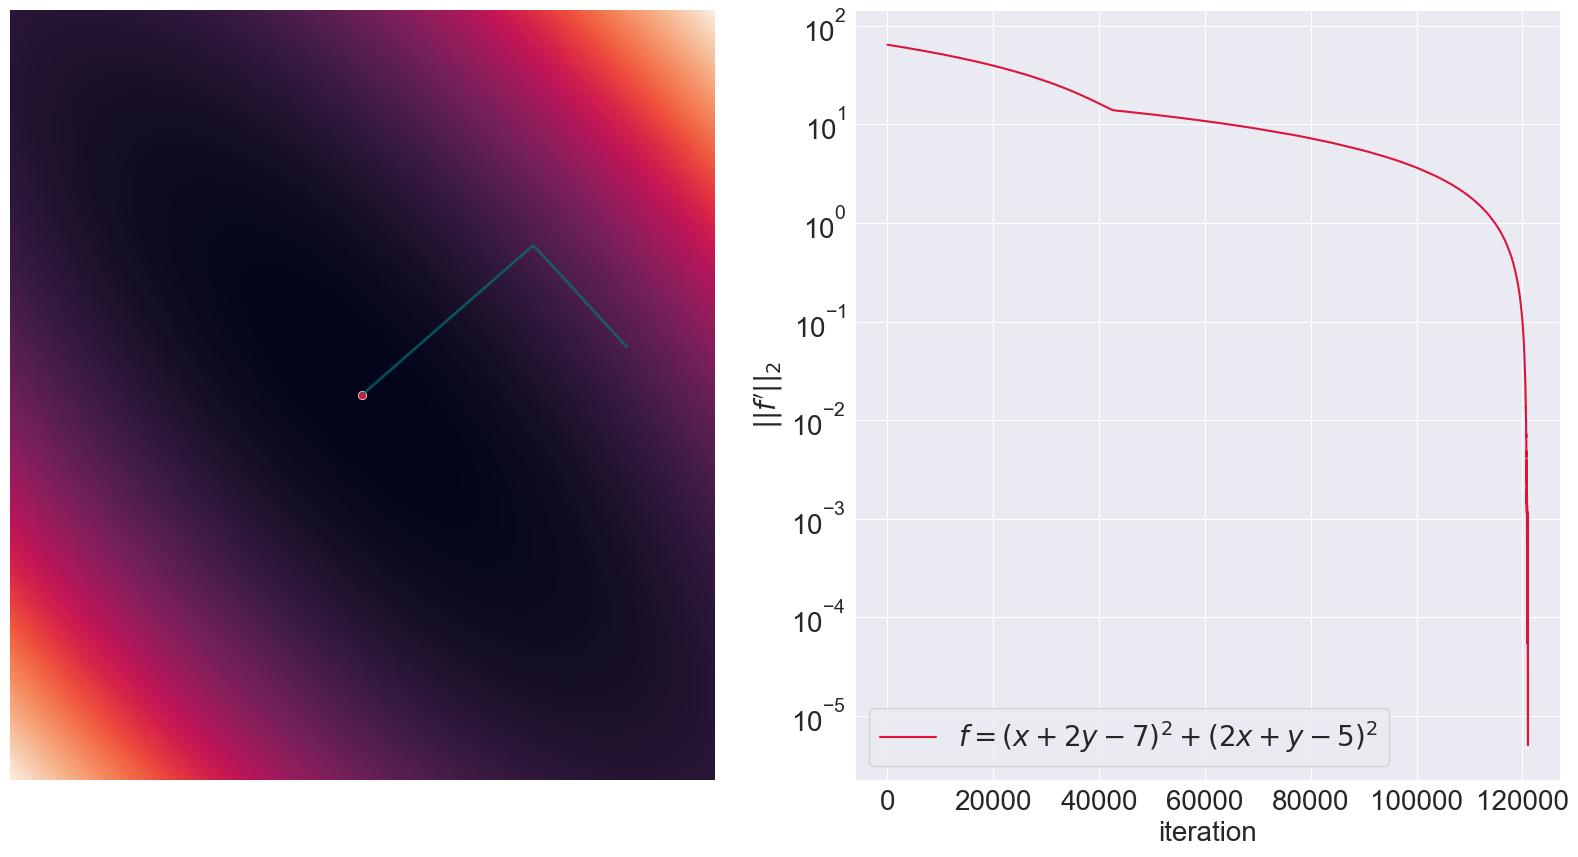

In [341]:
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
drawHeatmap(boothFunction, (1, 3), points=history, delta=8, ax=ax[0])
# fig.suptitle(f"Booth function optimization, Adam")
sns.lineplot(x=np.arange(1, len(loss) + 1), y=loss, ax=ax[1],
             color='crimson', label="$f=(x + 2y - 7)^2 + (2x + y - 5)^2$")
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("$||f'||_2$")
ax[1].set_yscale('log')
None


In [410]:
x = torch.tensor(7.0, requires_grad=True, device='cpu')
y = torch.tensor(2.0, requires_grad=True, device='cpu')
optimizer = torch.optim.Adam([x, y], lr=1e-4 / 2)

In [411]:
%%timeit
for i in range(200000):
    ft = boothFunction(x, y)
    optimizer.zero_grad()
    ft.backward()
    optimizer.step()
(x.detach().cpu().numpy(), y.detach().cpu().numpy())


CPU times: user 22.5 s, sys: 198 ms, total: 22.7 s
Wall time: 22.8 s


(array(1., dtype=float32), array(3., dtype=float32))

In [414]:
x, y = sg.Variable(7), sg.Variable(2)
f = boothFunction(x, y)
f.forward()
f.backward()
optimizer = sgo.Adam(model=f, variables=[x, y], lr=1e-4 / 2)

In [415]:
%%timeit
for i in range(200000):
    optimizer.step()
(x.scalar, y.scalar)

CPU times: user 12.3 s, sys: 49.4 ms, total: 12.4 s
Wall time: 12.4 s


(1.0000395137978688, 3.000039513797869)

In [416]:
12.4 / 22.8


0.543859649122807